# Domain-Aware UI/UX Reviewer Agent: Custom Tools with Retry and Fallback


*Notebook by [Mayank Laddha](https://www.linkedin.com/in/mayankladdha31/)*

In this notebook, we'll build an agent to analyze a web page using both desktop and mobile views. We define simple, optional tools to obtain readability scores, HTML structure, and performance-related data as needed.

Additionally, we'll extend the [`Tool`](https://docs.haystack.deepset.ai/docs/tool) class to implement retry and fallback mechanisms for tools.

Our stack:
- [Haystack Agentic framework](https://github.com/deepset-ai/haystack) -  to build our agent
- [Playwright](https://playwright.dev/) - for taking screenshots of the website
- [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/) - for scraping HTML text content
- [Textstat](https://textstat.org/) - for calculating text readability

## Setting up the Environment

First, we'll install all the necessary dependencies:

In [1]:
!pip install -q playwright textstat haystack-ai beautifulsoup4 requests
!playwright install --with-deps chromium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.7/643.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.1 MB/s eta 0:00:00
Installing dependencies...
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://cli.github.com/packages stable/main amd64 Packages [354 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get

Add credentials for OpenAI API

In [2]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

Enter OpenAI API key:··········


In [3]:
import textstat
from bs4 import BeautifulSoup
from collections import Counter
import base64
import json
from playwright.async_api import async_playwright
from haystack.components.agents import Agent
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage, ImageContent
from haystack.tools import Tool
from haystack.tools.errors import ToolInvocationError
from haystack.utils.callable_serialization import deserialize_callable, serialize_callable
from haystack.components.generators.utils import print_streaming_chunk
from PIL import Image
from io import BytesIO
import base64
from IPython.display import display,Markdown,Image as IPyImage
import inspect
import requests
import pprint
import logging
from urllib.parse import urlparse


SHARED_DATA = {}
logger = logging.getLogger(__name__)

## Defining Tools and Utility Functions

Let's define a function to capture desktop and mobile screenshots along with the HTML using Playwright. We use Playwright's asynchronous (async) API when running in Google Colab, since the synchronous Playwright API can have issues in the Colab environment. We also define a function that returns the root url.

In [4]:
async def capture_page(url:str):
    """get screenshots using playwright"""
    screenshots_b64 = []

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        await page.add_style_tag(
            content="* { animation: none !important; transition: none !important; }"
        )

        await page.goto(url, wait_until="domcontentloaded", timeout=30000)

        viewports = {
            "desktop": (1920, 1080),
            "mobile": (375, 812)
        }

        for name, (w, h) in viewports.items():
            await page.set_viewport_size({"width": w, "height": h})

            img_bytes = await page.screenshot(
                full_page=True,
                type="png"
            )

            screenshots_b64.append(base64.b64encode(img_bytes).decode("utf-8"))

        html = await page.content()

        await browser.close()

    return screenshots_b64, html

def get_root_url(url_string):
    """
    Checks if a URL can be parsed and returns the root URL (scheme + netloc).
    """
    try:
        parsed = urlparse(url_string)
        if all([parsed.scheme, parsed.netloc]):
            return f"{parsed.scheme}://{parsed.netloc}"
        return None
    except ValueError:
        return None


Let's now define the tool functionalities:

*   `html_analyzer` - to get the HTML structure
*   `get_readability_score` - to get readability score using textstat
*   `get_performance` - **we intentionally force it to fail to see if retry and fallback work**
*   `get_performance_fallback` - fallback functionality for the `get_performance` tool
*   `image_weight_analyzer` - get image count along with the size of the largest image




In [5]:
def html_analyzer(url:str):
    html = SHARED_DATA[url][1]
    soup = BeautifulSoup(html, "html.parser")
    tags = [tag.name for tag in soup.find_all(True)]
    tag_counts = Counter(tags)

    def exists(tag):
        return tag_counts.get(tag, 0) > 0

    headings = {
        "h1_count": tag_counts.get("h1", 0),
        "h2_count": tag_counts.get("h2", 0),
        "h3_count": tag_counts.get("h3", 0)
    }

    max_depth = max(
        len(list(tag.parents))
        for tag in soup.find_all(True)
    )

    total_tags = len(tags)
    div_ratio = round(tag_counts.get("div", 0) / total_tags, 2) if total_tags else 0

    return json.dumps({
        "sections": {
            "header": exists("header"),
            "nav": exists("nav"),
            "main": exists("main"),
            "footer": exists("footer")
        },
        "headings": headings,
        "ctas": {
            "buttons": tag_counts.get("button", 0),
            "links": tag_counts.get("a", 0),
            "primary_cta_present": tag_counts.get("button", 0) > 0
        },
        "forms": {
            "form_count": tag_counts.get("form", 0),
            "input_count": tag_counts.get("input", 0)
        },
        "media": {
            "images": tag_counts.get("img", 0),
            "videos": tag_counts.get("video", 0)
        },
        "complexity": {
            "max_dom_depth": max_depth,
            "div_ratio": div_ratio
        }
    })


def get_readability_score(url:str):
    html = SHARED_DATA[url][1]
    soup = BeautifulSoup(html, "html.parser")
    text = soup.get_text(separator="\n",strip=True)[:500]
    return "Flesch-Kincaid Grade: "+str(textstat.flesch_kincaid_grade(text))+"\n(This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.)"


def get_performance(url: str):
    r = requests.get(
        "https://www.invalid-url-for-testing.com",  # invalid domain to make it fail
        params={"url": url, "category": "performance"}
    )
    r.raise_for_status()


def get_performance_fallback(url: str):
    r = requests.get(url, timeout=10)
    html = r.text
    soup = BeautifulSoup(html, "html.parser")

    return json.dumps({
        "request_duration_ms": r.elapsed.total_seconds() * 1000,
        "html_kb": len(r.content) / 1024,
    })

def image_weight_analyzer(url:str):
    html = SHARED_DATA[url][1]
    soup = BeautifulSoup(html, "html.parser")
    images = soup.find_all("img")

    sizes = []
    for img in images:
        w = img.get("width")
        h = img.get("height")
        if w and h and w.isdigit() and h.isdigit():
            sizes.append(int(w) * int(h))

    return json.dumps({
        "image_count": len(images),
        "largest_image_pixels(w * h)": max(sizes) if sizes else 0
    })


## Creating a Custom Tool with Retry and Fallback Mechanism

This `CustomTool` extends Haystack’s [`Tool`](https://docs.haystack.deepset.ai/docs/tool) class to add **retry logic** and a **fallback mechanism**.

- Tools can fail for many practical reasons (unstable networks, unreliable APIs)
- Fallback functions often **do not share the exact same signature** as the main tool.
- We want fallbacks to:
  - Reuse tool inputs when possible
  - Accept a **subset of parameters** or **no parameters**


In [6]:
from dataclasses import dataclass
from typing import Callable, Any

@dataclass
class CustomTool(Tool):
    retry: int = 0
    fallback_function: Callable | None = None

    def _invoke_fallback(self, **kwargs: Any) -> Any:
        fn = self.fallback_function

        sig = inspect.signature(fn)

        if any(p.kind == p.VAR_KEYWORD for p in sig.parameters.values()):
            return fn(**kwargs)

        filtered = {
            k: v for k, v in kwargs.items()
            if k in sig.parameters
        }

        return fn(**filtered)


    def invoke(self, **kwargs: Any) -> Any:
        last_error = None

        for attempt in range(self.retry + 1):
            try:
                return self.function(**kwargs)
            except Exception as e:
                last_error = e
                if attempt < self.retry:
                    continue
                break

        if self.fallback_function is not None:
            logger.warning(
                "\nTool `%s` failed after %d attempts. Using fallback function. Error: %s",
                self.name,
                self.retry + 1,
                last_error,
            )
            try:
                return self._invoke_fallback(**kwargs)
            except Exception as fallback_error:
                raise ToolInvocationError(
                    f"Tool `{self.name}` failed after {self.retry + 1} attempts "
                    f"and fallback also failed. "
                    f"Main error: {last_error}, Fallback error: {fallback_error}",
                    tool_name=self.name,
                ) from fallback_error

        raise ToolInvocationError(
            f"Tool `{self.name}` failed after {self.retry + 1} attempts. "
            f"Last error: {last_error}",
            tool_name=self.name,
        ) from last_error


    def to_dict(self) -> dict[str, Any]:
        base = super().to_dict()
        data = base["data"]

        data["retry"] = self.retry

        if self.fallback_function is not None:
            data["fallback_function"] = serialize_callable(self.fallback_function)
        else:
            data["fallback_function"] = None

        return base

    @classmethod
    def from_dict(cls, data: dict[str, Any]) -> "CustomTool":
        tool = super(CustomTool, cls).from_dict(data)

        if tool.fallback_function is not None:
            tool.fallback_function = deserialize_callable(tool.fallback_function)

        return tool



## Creating the UI/UX Reviewer Agent

Let's define our workflow:


* Get desktop and mobile screenshots along with the HTML using playwright through the function we defined earlier
* Use **Tool** class to convert functionalities into tools. Note that we have set a retry and a fallback function for the `CustomTool` responsible for fetching performance-related data
* Define the agent, we use `gpt4o-mini` for testing

We keep `max_agent_steps = 5` but feel free to increase it.  

As the output, we'll receive a feedback based on:

* Content (how suitable and effective the content is for the given domain)
* Layout (layout quality, CTAs and ease of navigation)
* Visuals and Performance



In [7]:
def run_agent(url:str, web_data:tuple):
    tools = [
        Tool(
            name="html_analyzer",
            description="Returns html structure of the landing page.",
            parameters={
                "type": "object",
                "properties": {
                    "url": {"type": "string", "description": "url of the landing page"}
                },
                "required": ["url"]
            },
            function=html_analyzer
        ),
        Tool(
            name="get_readability_score",
            description="Returns readability score of the landing page.",
            parameters={
                "type": "object",
                "properties": {
                    "url": {"type": "string", "description": "url of the landing page"}
                },
                "required": ["url"]
            },
            function=get_readability_score
        ),
        Tool(
            name="image_weight_analyzer",
            description="Returns image count and largest image size on the landing page.",
            parameters={
                "type": "object",
                "properties": {
                    "url": {"type": "string", "description": "url of the landing page"}
                },
                "required": ["url"]
            },
            function=image_weight_analyzer
        ),
        CustomTool(
            name="performance",
            description="Returns largest contentful paint",
            parameters={
                "type": "object",
                "properties": {
                    "url": {"type": "string", "description": "url of the landing"}
                    },
                "required": ["url"]
            },
            function=get_performance,
            retry=1,
            fallback_function=get_performance_fallback
        ),
    ]

    agent = Agent(
        chat_generator=OpenAIChatGenerator(model="gpt-4o-mini",generation_kwargs={"max_completion_tokens":3000,"temperature":0.2}),
        tools=tools,
        max_agent_steps = 5,
        streaming_callback=print_streaming_chunk
    )

    prompt = f"""
    You are an expert in UI/UX. You are given desktop and mobile views, along with performance data, for a landing page. First, determine the domain based on the page content, and then analyze the landing page from a UI/UX perspective.

    Make sure to consider the domain during your analysis. For example, a finance website may have very different requirements compared to a travel website. Some websites require higher readability, while others should focus more on wonderful visuals and engagement and less on readability.

    Some websites need better performance, for some it might not be a priority.

    You are also provided with tools to:

    - analyze the HTML structure,

    - get perfromance related data,

    - extract image-related data, and

    - calculate a readability score.

    The use of these tools is optional. Decide which tools are needed and use them if they help you provide better feedback.

    Provide both positive and negative feedback on the following aspects, considering both desktop and mobile views:

    - Content (how suitable and effective the content is for the given domain)

    - Layout (layout quality, CTAs and ease of navigation)

    - Visuals (design, responsiveness, and visual quality, considering the domain)

    - Performance (only if applicable)

    - Actionable improvements

    Do not make up information. Speak like a ui/ux expert using simple informal english. Return the feedback in Markdown format.
    URL: {url}
    """
    screenshots = web_data[0]
    desktop_content = ImageContent(base64_image=f"{screenshots[0]}",detail="low")
    mobile_content =  ImageContent(base64_image=f"{screenshots[1]}",detail="low")
    result = agent.run(
        messages=[ChatMessage.from_user(content_parts=[prompt,desktop_content,mobile_content])]
    )
    feedback = result["messages"][-1].text
    tool_calls = [message.tool_calls for message in result["messages"] if message.tool_calls]
    tool_call_results = [message.tool_call_results for message in result["messages"] if message.tool_call_results]
    pil_images = [Image.open(BytesIO(base64.b64decode(screenshots[0]))),Image.open(BytesIO(base64.b64decode(screenshots[1])))]
    return feedback,pil_images, tool_calls, tool_call_results


async def get_screenshots(url:str):
    # since we are focusing on the landing page only
    root_url = get_root_url(url)
    if not root_url:
        raise ValueError(f"Invalid URL provided: {url}. Please provide a valid URL including the scheme, e.g. 'https://example.com' or 'http://example.com'.")
    web_data = await capture_page(root_url)
    SHARED_DATA[root_url] = web_data
    return root_url,web_data


### Testing the Agent

We can directly await in colab as it already has an active asyncio event loop running in the background by default. No need to worry about 'await only allowed within async function' error. This step will take some time ⏳

In [9]:
# get screenshots with playwright, we await it before running the agent. (sync version of playwright does not work properly on colab)

root_url, web_data = await get_screenshots("https://visitors.now/")

# let's run our agent

feedback, pil_images, tool_calls, tool_call_results = run_agent(root_url,web_data)


[TOOL CALL]
Tool: html_analyzer 
Arguments: {"url": "https://visitors.now"}

[TOOL CALL]
Tool: get_readability_score 
Arguments: {"url": "https://visitors.now"}

[TOOL CALL]
Tool: image_weight_analyzer 
Arguments: {"url": "https://visitors.now"}

[TOOL CALL]
Tool: performance 
Arguments: {"url": "https://visitors.now"}

[TOOL RESULT]
{"sections": {"header": true, "nav": true, "main": false, "footer": true}, "headings": {"h1_count": 1, "h2_count": 12, "h3_count": 18}, "ctas": {"buttons": 37, "links": 36, "primary_cta_present": true}, "forms": {"form_count": 0, "input_count": 0}, "media": {"images": 5, "videos": 0}, "complexity": {"max_dom_depth": 24, "div_ratio": 0.47}}

Tool `performance` failed after 2 attempts. Using fallback function. Error: HTTPSConnectionPool(host='www.invalid-url-for-testing.com', port=443): Max retries exceeded with url: /?url=https%3A%2F%2Fvisitors.now&category=performance (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x79ade0e40a70>: Failed to resolve 'www.invalid-url-for-testing.com' ([Errno -2] Name or service not known)"))




[TOOL RESULT]
Flesch-Kincaid Grade: 10.215740740740742
(This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.)

[TOOL RESULT]
{"image_count": 5, "largest_image_pixels(w * h)": 5184000}

[TOOL RESULT]
{"request_duration_ms": 138.15099999999998, "html_kb": 159.4765625}

[ASSISTANT]
# UI/UX Analysis of Visitors.now

## Domain Overview
Based on the URL and content, it appears that this website is focused on visitor analytics or tracking. This domain typically requires clear, concise information and effective data visualization to help users understand their visitor metrics.

## Content
### Positive Feedback
- **Clarity**: The content is generally clear and informative, which is essential for users looking to understand analytics.
- **Headings**: The use of multiple headings (1 H1, 12 H2s, and 18 H3s) helps in organizing information, making it easier for users to scan through.

### Negative Feedback
- **Readability**: The Flesch-Kinca

By enabling streaming with `streaming_callback=print_streaming_chunk`, we can observe tool calls, tool outputs, and the agent's final response in real time.


Let's check if the taken screenshots were correct

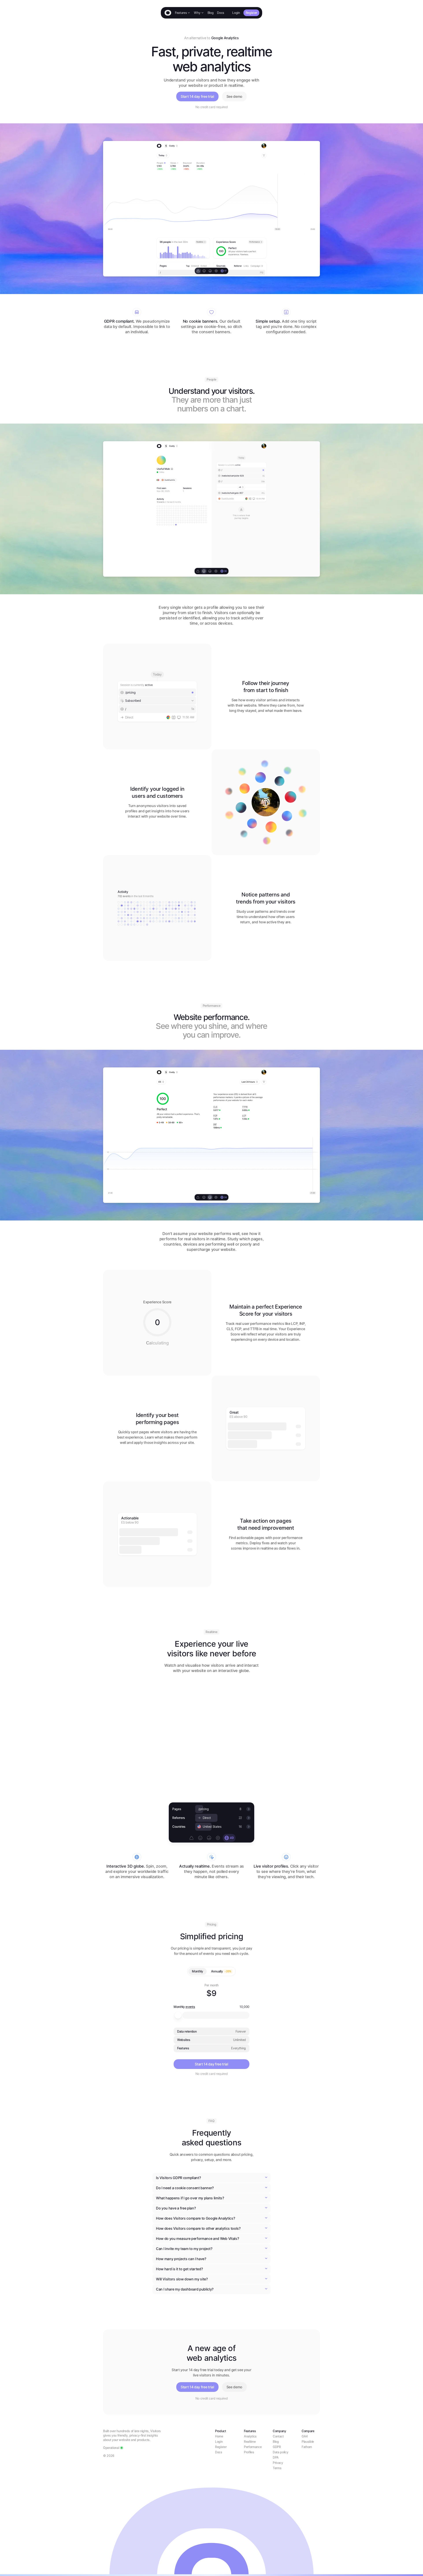

In [10]:
def display_preview(img, width = 800):
    buf = BytesIO()
    img.save(buf, format="PNG")
    display(IPyImage(data=buf.getvalue(), width = width))

display_preview(pil_images[0])

## Rendering the Feedback

Display the feedback properly as markdown.

In [ ]:
Markdown(feedback)

## Inspecting the Tool Calls and Results

In [11]:
pprint.pprint(tool_calls)

[[ToolCall(tool_name='html_analyzer',
           arguments={'url': 'https://visitors.now'},
           id='call_K0TwgDTAHvVhnBrQmqDc0z2w',
           extra=None),
  ToolCall(tool_name='get_readability_score',
           arguments={'url': 'https://visitors.now'},
           id='call_WOpxYRxtj0GwbzVc8q0zFNK9',
           extra=None),
  ToolCall(tool_name='image_weight_analyzer',
           arguments={'url': 'https://visitors.now'},
           id='call_UtppthsQewEYC99o0XdH26gn',
           extra=None),
  ToolCall(tool_name='performance',
           arguments={'url': 'https://visitors.now'},
           id='call_cN22KmIGSfWhdHRTAREmx98B',
           extra=None)]]


In [12]:
pprint.pprint(tool_call_results)

[[ToolCallResult(result='{"sections": {"header": true, "nav": true, "main": '
                        'false, "footer": true}, "headings": {"h1_count": 1, '
                        '"h2_count": 12, "h3_count": 18}, "ctas": {"buttons": '
                        '37, "links": 36, "primary_cta_present": true}, '
                        '"forms": {"form_count": 0, "input_count": 0}, '
                        '"media": {"images": 5, "videos": 0}, "complexity": '
                        '{"max_dom_depth": 24, "div_ratio": 0.47}}',
                 origin=ToolCall(tool_name='html_analyzer',
                                 arguments={'url': 'https://visitors.now'},
                                 id='call_K0TwgDTAHvVhnBrQmqDc0z2w',
                                 extra=None),
                 error=False)],
 [ToolCallResult(result='Flesch-Kincaid Grade: 10.215740740740742\n'
                        '(This is a grade formula in that a score of 9.3 means '
                        'that a nint

We see in the last `ToolCallResult` that the agent originally called the `performance` tool but since we forced that tool to fail, the input was passed to the fallback function `get_performance_fallback` that returned `"request_duration_ms"` and `"html_kb"` info instead.

That's it! 🎉 If you want to test this with a UI, check out the [Domain Aware UI/UX Reviewer Agent demo](https://github.com/maylad31/uiux_reviewer_agent)